In [1]:
# Data directory /Users/scott/p5/data/interim/n35_train_valid_test

In [2]:
import numpy as np
import pandas as pd
import keras
from keras import backend as K
from keras.preprocessing import image
from keras.applications.vgg19 import decode_predictions
from keras.models import Sequential, Model
from keras.layers import Activation
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam, SGD
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
from glob import glob
import os.path
import PIL
import cv2
import re
from collections import defaultdict, namedtuple

from PIL import Image
from io import BytesIO
from IPython.display import HTML

Using TensorFlow backend.


In [3]:
pd.set_option('display.max_colwidth', -1)

def get_thumbnail(path):
    i = Image.open(path)
    i.thumbnail((150, 150), Image.LANCZOS)
    return i

def image_base64(im):
    if isinstance(im, str):
        im = get_thumbnail(im)
    with BytesIO() as buffer:
        im.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()

def image_formatter(im):
    return f'<img src="data:image/jpeg;base64,{image_base64(im)}">'

In [4]:
pd.set_option('display.max_columns', None)

In [5]:
def get_classes(path):
    directories = glob(os.path.expanduser(path) + '/*')
    return [dir.split('/')[-1] for dir in directories]
n_classes =  len(get_classes('/home/scott/p5/data/interim/n35_train_valid_test/train'))
n_classes

2

In [6]:
def to_gray_scale(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_image = cv2.cvtColor(image,cv2.COLOR_GRAY2BGR)
    return np.array(gray_image)

In [7]:
def gray_and_scale(image):
    return cv2.resize(to_gray_scale(image), (224, 224))

In [30]:
def get_heat_value(img_segment, model, labels):
    resized_and_grayscaled_image = cv2.resize(to_gray_scale(img_segment), (224, 224))
    pred_array = model.predict(np.expand_dims(resized_and_grayscaled_image, axis=0))
    return pred_array
#     if labels[np.argmax(pred_array)] == 'N35':
#         return 1
#     elif labels[np.argmax(pred_array)] == 'N35_part':
#         return 0.5
#     else:
#         return 0
    
# get_heat_value(img_part, model, labels)

In [9]:
 vgg19 = keras.applications.vgg19.VGG19(weights='imagenet', include_top=False, input_shape=(224,224, 3))

In [10]:
# note we exclude the final dense layers and add one back below, we would retrain it ourselves
base_model = vgg19
 
# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False 
    
x = base_model.output
x = Flatten()(x) # flatten from convolution tensor output 
predictions = Dense(n_classes, activation='softmax')(x) # should match # of classes predicted

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [12]:
train_path = os.path.expanduser('/home/scott/p5/data/interim/n35_train_valid_test/train')
test_path = os.path.expanduser('/home/scott/p5/data/interim/n35_train_valid_test/test')
valid_path = os.path.expanduser('/home/scott/p5/data/interim/n35_train_valid_test/valid')

In [13]:
train_batches = ImageDataGenerator(preprocessing_function=to_gray_scale).flow_from_directory(train_path,
                                                         target_size=(224,224), 
                                                         batch_size=6)
valid_batches = ImageDataGenerator(preprocessing_function=to_gray_scale).flow_from_directory(valid_path, 
                                                         target_size=(224,224), 
                                                         batch_size=5)
test_batches = ImageDataGenerator(preprocessing_function=to_gray_scale).flow_from_directory(test_path, 
                                                        target_size=(224,224),
                                                        shuffle=False,
                                                        batch_size=1)


Found 413 images belonging to 2 classes.
Found 89 images belonging to 2 classes.
Found 89 images belonging to 2 classes.


In [ ]:
# sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
# model.compile(Adam(lr=0.00002), loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(Adam(lr=0.00002), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# patient early stopping
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)
# mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
hist = model.fit_generator(train_batches, 
                    steps_per_epoch=4, 
                    validation_data=valid_batches, 
                    validation_steps=4,
                    epochs=100,
                    verbose=2)#, 
#                     callbacks=[es, mc])

In [ ]:
for key in hist.history:
    print(key)

In [ ]:
asdf =

In [ ]:
!ls

In [ ]:
# model.save('hieroglyphs_vgg19_N35_only_custom_images.h5')

In [14]:
model = load_model(os.path.expanduser('hieroglyphs_vgg19_N35_only_custom_images_two_class.h5'))



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [ ]:
# predictions = model.predict_generator(test_batches, steps=1, verbose=1)

In [15]:
STEP_SIZE_TEST=test_batches.n//test_batches.batch_size
test_batches.reset()
pred=model.predict_generator(test_batches,
steps=STEP_SIZE_TEST,
verbose=1)
# print(pred)

89/89 [==============================] - 15s 172ms/step


In [16]:
predicted_class_indices=np.argmax(pred,axis=1)
predicted_class_indices

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1])

In [17]:
labels = (train_batches.class_indices)
print(labels)
labels = dict((v,k) for k,v in labels.items())
print(labels)
predictions = [labels[k] for k in predicted_class_indices]

{'N35': 0, 'noise': 1}
{0: 'N35', 1: 'noise'}


In [18]:
predictions[:11]

['N35', 'N35', 'N35', 'N35', 'N35', 'N35', 'noise', 'N35', 'N35', 'N35', 'N35']

In [19]:
def get_glyph_name(series):
    file = series['filename']
    m = re.match(r'^([A-Z]{1}\d+)/', file)
    part = re.search(r'(N35_part)/', file)
    if m:
        return m.group(1)
    elif part:
        return part.group(1)
    else:
        return 'noise'

In [20]:
pred_df = pd.DataFrame(predictions, columns=['predicted'])
pred_df = pred_df.merge(pd.DataFrame(test_batches.filenames, columns=['filename']), left_index=True, right_index=True)
pred_df['glyph'] = pred_df.apply(lambda row: get_glyph_name(row), axis=1)
pred_df['match'] = pred_df['predicted'] == pred_df['glyph']
pred_df.to_csv('/Users/scott/p5/N35_predictions_custom_images.csv', index=False)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/scott/p5/N35_predictions_custom_images.csv'

In [21]:
acc = pred_df['match'].sum() / len(pred_df)
acc

0.9775280898876404

In [22]:
pred_df.sample(5)

,predicted,filename,glyph,match
69,noise,noise/img_x_501_y_289.png,noise,True
1,N35,N35/img_x_1008_y_794.png,N35,True
27,N35,N35/img_x_488_y_511.png,N35,True
56,noise,noise/img_x_1933_y_743.png,noise,True
70,noise,noise/img_x_598_y_512.png,noise,True


(150, 350, 3)


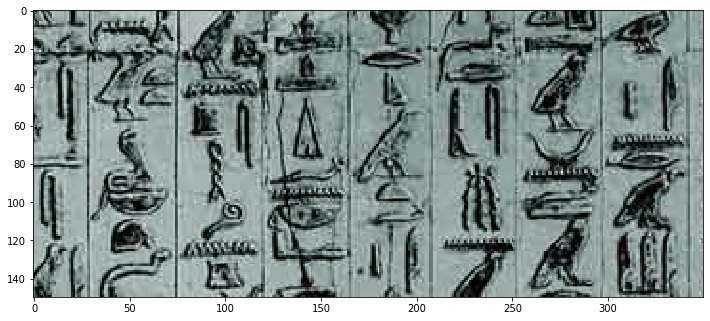

In [31]:
# Orig Image Shape (1507, 1720, 3)
# img = cv2.imread('/home/scott/sync/Antewest.jpg')[250:1000, 1220:]
img = cv2.imread('/home/scott/sync/Antewest.jpg')[250:400, 1220:1570]
print(img.shape)
plt.figure(figsize=(12,12))
plt.imshow(img)


In [59]:
heat_map = []
window_height = 40
window_width = 40
for y_step in range(0, img.shape[0], 5):
    for x_step in range(0, img.shape[1], 5):
        print((x_step, y_step))
        # Get window_width x window_height image segement
        crop_img = img[y_step:y_step+window_height, x_step:x_step+window_width].copy()
        # Get the heat value of the image segemnt
        heat = get_heat_value(crop_img, model, labels)
        # Appened heat value to heat map
        print(heat)
        heat_map.append(heat)

(0, 0)
[[1.1189001e-04 9.9988806e-01]]
(5, 0)
[[0.9858035  0.01419652]]
(10, 0)
[[9.9999964e-01 3.5446249e-07]]
(15, 0)
[[8.3490846e-08 9.9999988e-01]]
(20, 0)
[[0.0045206  0.99547935]]
(25, 0)
[[9.9940789e-01 5.9214496e-04]]
(30, 0)
[[9.9999619e-01 3.8499256e-06]]
(35, 0)
[[0.85992855 0.14007142]]
(40, 0)
[[6.0463262e-05 9.9993956e-01]]
(45, 0)
[[0.03963214 0.9603679 ]]
(50, 0)
[[8.8147345e-10 1.0000000e+00]]
(55, 0)
[[3.506275e-16 1.000000e+00]]
(60, 0)
[[5.4694124e-11 1.0000000e+00]]
(65, 0)
[[7.231846e-12 1.000000e+00]]
(70, 0)
[[2.9889044e-13 1.0000000e+00]]
(75, 0)
[[2.6004578e-13 1.0000000e+00]]
(80, 0)
[[3.470037e-05 9.999653e-01]]
(85, 0)
[[9.9999988e-01 1.0567304e-07]]
(90, 0)
[[9.9969327e-01 3.0679596e-04]]
(95, 0)
[[5.8463984e-04 9.9941540e-01]]
(100, 0)
[[5.037684e-09 1.000000e+00]]
(105, 0)
[[2.4909141e-10 1.0000000e+00]]
(110, 0)
[[1.2503812e-04 9.9987495e-01]]
(115, 0)
[[6.0996463e-05 9.9993896e-01]]
(120, 0)
[[0.02652167 0.9734784 ]]
(125, 0)
[[9.992483e-01 7.516067e-0

[[0.9817463  0.01825362]]
(30, 15)
[[3.0760202e-06 9.9999690e-01]]
(35, 15)
[[0.00157129 0.99842864]]
(40, 15)
[[0.9500592  0.04994082]]
(45, 15)
[[0.99882203 0.00117796]]
(50, 15)
[[0.6759293  0.32407063]]
(55, 15)
[[1.785722e-07 9.999999e-01]]
(60, 15)
[[5.5511116e-09 1.0000000e+00]]
(65, 15)
[[0.26543748 0.73456246]]
(70, 15)
[[3.533400e-05 9.999647e-01]]
(75, 15)
[[0.32329297 0.67670697]]
(80, 15)
[[1.2579383e-04 9.9987423e-01]]
(85, 15)
[[0.4429474  0.55705255]]
(90, 15)
[[0.01601224 0.9839878 ]]
(95, 15)
[[0.00381595 0.99618405]]
(100, 15)
[[1.1157357e-04 9.9988842e-01]]
(105, 15)
[[4.5594334e-07 9.9999952e-01]]
(110, 15)
[[1.5765925e-05 9.9998426e-01]]
(115, 15)
[[2.2167505e-07 9.9999976e-01]]
(120, 15)
[[0.00613785 0.99386215]]
(125, 15)
[[8.7194632e-05 9.9991274e-01]]
(130, 15)
[[0.22016627 0.77983373]]
(135, 15)
[[1.37264005e-08 1.00000000e+00]]
(140, 15)
[[1.3321336e-10 1.0000000e+00]]
(145, 15)
[[8.0321544e-10 1.0000000e+00]]
(150, 15)
[[1.0609149e-07 9.9999988e-01]]
(155, 

[[5.7560245e-13 1.0000000e+00]]
(45, 30)
[[1.2306796e-09 1.0000000e+00]]
(50, 30)
[[1.3072633e-07 9.9999988e-01]]
(55, 30)
[[3.9423785e-15 1.0000000e+00]]
(60, 30)
[[1.653939e-13 1.000000e+00]]
(65, 30)
[[3.9020978e-09 1.0000000e+00]]
(70, 30)
[[0.88377714 0.11622289]]
(75, 30)
[[0.68907803 0.31092194]]
(80, 30)
[[0.15606244 0.8439375 ]]
(85, 30)
[[9.9995899e-01 4.0953506e-05]]
(90, 30)
[[0.8205863  0.17941369]]
(95, 30)
[[9.9961591e-01 3.8405857e-04]]
(100, 30)
[[9.999999e-01 8.315361e-08]]
(105, 30)
[[0.41074333 0.58925664]]
(110, 30)
[[0.97968    0.02032004]]
(115, 30)
[[2.4760558e-04 9.9975234e-01]]
(120, 30)
[[3.0314768e-09 1.0000000e+00]]
(125, 30)
[[2.4523547e-12 1.0000000e+00]]
(130, 30)
[[4.848527e-10 1.000000e+00]]
(135, 30)
[[2.709745e-12 1.000000e+00]]
(140, 30)
[[4.6349626e-12 1.0000000e+00]]
(145, 30)
[[4.3427397e-12 1.0000000e+00]]
(150, 30)
[[1.25874224e-17 1.00000000e+00]]
(155, 30)
[[1.9984386e-10 1.0000000e+00]]
(160, 30)
[[1.2356817e-06 9.9999881e-01]]
(165, 30)
[[8

[[9.1790440e-07 9.9999905e-01]]
(45, 45)
[[3.110231e-11 1.000000e+00]]
(50, 45)
[[5.987328e-17 1.000000e+00]]
(55, 45)
[[1.242913e-13 1.000000e+00]]
(60, 45)
[[2.9666143e-15 1.0000000e+00]]
(65, 45)
[[4.3139884e-11 1.0000000e+00]]
(70, 45)
[[9.6140830e-06 9.9999034e-01]]
(75, 45)
[[9.9947780e-01 5.2223203e-04]]
(80, 45)
[[1.0000000e+00 2.3554922e-09]]
(85, 45)
[[0.7867048  0.21329522]]
(90, 45)
[[1.682238e-05 9.999832e-01]]
(95, 45)
[[2.0976356e-06 9.9999785e-01]]
(100, 45)
[[1.1352585e-10 1.0000000e+00]]
(105, 45)
[[5.562703e-14 1.000000e+00]]
(110, 45)
[[1.1685563e-08 1.0000000e+00]]
(115, 45)
[[7.168850e-08 9.999999e-01]]
(120, 45)
[[4.8294123e-06 9.9999511e-01]]
(125, 45)
[[4.8389175e-04 9.9951613e-01]]
(130, 45)
[[9.9948394e-01 5.1601965e-04]]
(135, 45)
[[9.9995589e-01 4.4133983e-05]]
(140, 45)
[[1.2681554e-09 1.0000000e+00]]
(145, 45)
[[1.632312e-04 9.998367e-01]]
(150, 45)
[[2.6236183e-10 1.0000000e+00]]
(155, 45)
[[9.444505e-09 1.000000e+00]]
(160, 45)
[[0.2558172  0.74418277]]

[[0.99207616 0.00792391]]
(40, 60)
[[1.000000e+00 4.621899e-11]]
(45, 60)
[[9.9999905e-01 8.9776802e-07]]
(50, 60)
[[6.7148484e-08 9.9999988e-01]]
(55, 60)
[[6.8396726e-17 1.0000000e+00]]
(60, 60)
[[1.7178974e-12 1.0000000e+00]]
(65, 60)
[[8.336946e-15 1.000000e+00]]
(70, 60)
[[2.7179994e-17 1.0000000e+00]]
(75, 60)
[[1.7676683e-07 9.9999988e-01]]
(80, 60)
[[1.000000e+00 9.341222e-13]]
(85, 60)
[[9.9999976e-01 2.2551322e-07]]
(90, 60)
[[0.98446596 0.01553397]]
(95, 60)
[[2.2831945e-10 1.0000000e+00]]
(100, 60)
[[8.034851e-10 1.000000e+00]]
(105, 60)
[[1.5179654e-13 1.0000000e+00]]
(110, 60)
[[5.340016e-10 1.000000e+00]]
(115, 60)
[[6.8326133e-15 1.0000000e+00]]
(120, 60)
[[1.5501953e-08 1.0000000e+00]]
(125, 60)
[[7.277119e-07 9.999993e-01]]
(130, 60)
[[3.855234e-08 1.000000e+00]]
(135, 60)
[[0.00127257 0.9987274 ]]
(140, 60)
[[2.0166318e-04 9.9979836e-01]]
(145, 60)
[[0.01149904 0.98850095]]
(150, 60)
[[1.7602991e-10 1.0000000e+00]]
(155, 60)
[[1.976411e-10 1.000000e+00]]
(160, 60)
[[

[[9.9919420e-01 8.0582936e-04]]
(45, 75)
[[0.00462953 0.99537045]]
(50, 75)
[[2.883069e-04 9.997117e-01]]
(55, 75)
[[5.774011e-10 1.000000e+00]]
(60, 75)
[[2.9171423e-26 1.0000000e+00]]
(65, 75)
[[6.8306486e-18 1.0000000e+00]]
(70, 75)
[[2.7333763e-10 1.0000000e+00]]
(75, 75)
[[0.03908002 0.96092004]]
(80, 75)
[[2.1177887e-06 9.9999785e-01]]
(85, 75)
[[2.7252224e-06 9.9999726e-01]]
(90, 75)
[[0.00669338 0.9933067 ]]
(95, 75)
[[0.99797493 0.00202502]]
(100, 75)
[[0.9906183  0.00938176]]
(105, 75)
[[9.2675565e-09 1.0000000e+00]]
(110, 75)
[[7.3005525e-05 9.9992704e-01]]
(115, 75)
[[0.80035156 0.19964853]]
(120, 75)
[[0.74758196 0.25241807]]
(125, 75)
[[1.0000000e+00 1.5893123e-10]]
(130, 75)
[[9.9999535e-01 4.6888431e-06]]
(135, 75)
[[2.457518e-13 1.000000e+00]]
(140, 75)
[[1.312714e-11 1.000000e+00]]
(145, 75)
[[6.711096e-07 9.999993e-01]]
(150, 75)
[[6.7931325e-08 9.9999988e-01]]
(155, 75)
[[4.3853134e-09 1.0000000e+00]]
(160, 75)
[[4.8111012e-04 9.9951887e-01]]
(165, 75)
[[0.00274602 

[[9.999062e-01 9.377316e-05]]
(45, 90)
[[0.00228969 0.99771035]]
(50, 90)
[[3.1078137e-10 1.0000000e+00]]
(55, 90)
[[7.6109454e-14 1.0000000e+00]]
(60, 90)
[[4.772288e-12 1.000000e+00]]
(65, 90)
[[2.7609348e-27 1.0000000e+00]]
(70, 90)
[[1.0766856e-14 1.0000000e+00]]
(75, 90)
[[0.40154478 0.5984552 ]]
(80, 90)
[[4.797237e-09 1.000000e+00]]
(85, 90)
[[5.1969732e-06 9.9999475e-01]]
(90, 90)
[[1.0341098e-04 9.9989653e-01]]
(95, 90)
[[0.2556496 0.7443504]]
(100, 90)
[[0.11660188 0.8833981 ]]
(105, 90)
[[3.1858847e-14 1.0000000e+00]]
(110, 90)
[[2.0813762e-07 9.9999976e-01]]
(115, 90)
[[0.9884614 0.0115386]]
(120, 90)
[[0.9976871  0.00231285]]
(125, 90)
[[0.8049138  0.19508612]]
(130, 90)
[[1.0000000e+00 4.0306274e-09]]
(135, 90)
[[0.99807185 0.00192819]]
(140, 90)
[[0.25926694 0.740733  ]]
(145, 90)
[[4.4308554e-14 1.0000000e+00]]
(150, 90)
[[3.4834025e-10 1.0000000e+00]]
(155, 90)
[[3.2473653e-07 9.9999964e-01]]
(160, 90)
[[0.8197333  0.18026668]]
(165, 90)
[[0.99665534 0.00334465]]
(170,

[[2.2932677e-10 1.0000000e+00]]
(35, 105)
[[1.4758433e-21 1.0000000e+00]]
(40, 105)
[[1.3495136e-14 1.0000000e+00]]
(45, 105)
[[1.5294141e-15 1.0000000e+00]]
(50, 105)
[[6.4738963e-24 1.0000000e+00]]
(55, 105)
[[2.5877874e-20 1.0000000e+00]]
(60, 105)
[[1.1060069e-18 1.0000000e+00]]
(65, 105)
[[3.1804522e-17 1.0000000e+00]]
(70, 105)
[[5.083866e-15 1.000000e+00]]
(75, 105)
[[5.7599603e-08 1.0000000e+00]]
(80, 105)
[[4.3490713e-06 9.9999571e-01]]
(85, 105)
[[0.9750623  0.02493777]]
(90, 105)
[[2.9756333e-07 9.9999976e-01]]
(95, 105)
[[3.301812e-11 1.000000e+00]]
(100, 105)
[[0.00760029 0.99239975]]
(105, 105)
[[7.402192e-07 9.999993e-01]]
(110, 105)
[[3.5710940e-07 9.9999964e-01]]
(115, 105)
[[3.0480576e-10 1.0000000e+00]]
(120, 105)
[[0.00104541 0.99895453]]
(125, 105)
[[0.9245795 0.0754205]]
(130, 105)
[[1.5747368e-05 9.9998426e-01]]
(135, 105)
[[0.05988297 0.94011706]]
(140, 105)
[[9.078871e-11 1.000000e+00]]
(145, 105)
[[3.3451928e-04 9.9966550e-01]]
(150, 105)
[[1.6473100e-04 9.998

[[2.2546018e-22 1.0000000e+00]]
(10, 120)
[[9.233649e-23 1.000000e+00]]
(15, 120)
[[6.425734e-20 1.000000e+00]]
(20, 120)
[[8.193993e-11 1.000000e+00]]
(25, 120)
[[9.9999905e-01 9.0303263e-07]]
(30, 120)
[[1.000000e+00 9.549124e-10]]
(35, 120)
[[4.0244188e-07 9.9999964e-01]]
(40, 120)
[[1.9165066e-07 9.9999976e-01]]
(45, 120)
[[9.994450e-01 5.549573e-04]]
(50, 120)
[[3.2753412e-08 1.0000000e+00]]
(55, 120)
[[9.9999475e-01 5.1925294e-06]]
(60, 120)
[[1.4278095e-05 9.9998569e-01]]
(65, 120)
[[4.035084e-15 1.000000e+00]]
(70, 120)
[[3.1333817e-11 1.0000000e+00]]
(75, 120)
[[0.0037323  0.99626774]]
(80, 120)
[[0.19325441 0.8067456 ]]
(85, 120)
[[9.0213529e-05 9.9990976e-01]]
(90, 120)
[[1.8952436e-05 9.9998105e-01]]
(95, 120)
[[9.992416e-01 7.583722e-04]]
(100, 120)
[[0.11627384 0.8837262 ]]
(105, 120)
[[1.389794e-10 1.000000e+00]]
(110, 120)
[[7.8287991e-07 9.9999917e-01]]
(115, 120)
[[3.351035e-10 1.000000e+00]]
(120, 120)
[[0.25048742 0.7495126 ]]
(125, 120)
[[0.99771893 0.00228108]]
(1

[[1.5231409e-06 9.9999845e-01]]
(340, 130)
[[6.2990744e-06 9.9999368e-01]]
(345, 130)
[[0.15633848 0.84366155]]
(0, 135)
[[2.2390093e-06 9.9999774e-01]]
(5, 135)
[[0.00801294 0.9919871 ]]
(10, 135)
[[1.0522926e-09 1.0000000e+00]]
(15, 135)
[[1.6222522e-05 9.9998379e-01]]
(20, 135)
[[9.2111164e-05 9.9990785e-01]]
(25, 135)
[[5.4178112e-05 9.9994576e-01]]
(30, 135)
[[1.8194265e-04 9.9981803e-01]]
(35, 135)
[[1.2978826e-08 1.0000000e+00]]
(40, 135)
[[1.3131973e-04 9.9986863e-01]]
(45, 135)
[[0.00273415 0.9972658 ]]
(50, 135)
[[0.01415986 0.9858401 ]]
(55, 135)
[[4.0190855e-05 9.9995983e-01]]
(60, 135)
[[1.0247073e-06 9.9999893e-01]]
(65, 135)
[[3.0073785e-04 9.9969923e-01]]
(70, 135)
[[0.09813136 0.9018687 ]]
(75, 135)
[[0.82211864 0.17788133]]
(80, 135)
[[2.0492403e-04 9.9979514e-01]]
(85, 135)
[[0.03493009 0.96506995]]
(90, 135)
[[4.263269e-09 1.000000e+00]]
(95, 135)
[[2.9810675e-05 9.9997020e-01]]
(100, 135)
[[0.00128072 0.99871933]]
(105, 135)
[[1.4149959e-10 1.0000000e+00]]
(110, 13

[[0.04613332 0.9538667 ]]
(320, 145)
[[0.01597248 0.9840275 ]]
(325, 145)
[[6.8919524e-04 9.9931085e-01]]
(330, 145)
[[0.00427351 0.99572647]]
(335, 145)
[[2.894322e-04 9.997105e-01]]
(340, 145)
[[5.982057e-07 9.999994e-01]]
(345, 145)
[[0.24649718 0.75350285]]


In [60]:
import pickle
with open(os.path.expanduser('~/p5/data/heatmap2.pkl'), 'wb') as f:
    pickle.dump(heat_map, f)

In [61]:
hm2 = heat_map.copy()

In [62]:
np_map = np.array(heat_map)
np_map.shape

(2100, 1, 2)

In [63]:
with open(os.path.expanduser('~/p5/data/heatmap2.pkl'), 'rb') as f:
    heat_map = pickle.load(f)

In [64]:
np_map = np.array(heat_map)


In [65]:
np_map.shape

(2100, 1, 2)

In [68]:
np_tmp = np_map[:, 0]
np_tmp = np_tmp[:, 0] 
np_tmp

array([1.1189001e-04, 9.8580348e-01, 9.9999964e-01, ..., 2.8943221e-04,
       5.9820570e-07, 2.4649718e-01], dtype=float32)

In [69]:
np_tmp2 = np_tmp > 0.9

In [70]:
np_tmp2.shape

(2100,)

In [71]:
np_tmp3 = np_tmp2.reshape((30, 70))

In [72]:
np_tmp4 = np.repeat(np.repeat(np_tmp3, 4, axis=0), 5, axis=1)

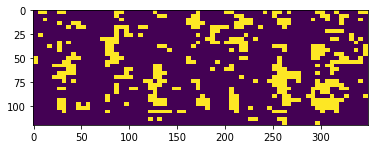

In [73]:
plt.imshow(np_tmp4)

In [ ]:
# np_map2 = np.reshape(np_map, (150, 100))

In [74]:
import heatmap
from scipy import ndimage
from skimage import io

ModuleNotFoundError: No module named 'heatmap'

In [ ]:
import seaborn as sns
plt.subplot
plt.figure(figsize=(10,12))
sns.heatmap(np.repeat(np.repeat(np_map2, 5, axis=0), 5, axis=1), cmap='Blues')
img2 = cv2.imread('/Users/scott/sync/Sync/hieroglyphs/Texts/Test_Image/Antewest.jpg')[250:1000, 1220:]
print(img2.shape)
plt.figure(figsize=(12,12))
plt.imshow(img)

In [ ]:
img_part = to_gray_scale(img[:40, :40])
plt.imshow(img_part)

In [ ]:

# labels[np.argmax(model.predict(np.expand_dims(cv2.resize(to_gray_scale(img[:40, :40]), (224, 224)), axis=0)))]

In [ ]:
np.array(None)

In [ ]:
1720 / 4 * 3

In [ ]:
1507 / 6

In [ ]:
m17 = pred_df[pred_df['predicted'] == 'M17']

In [ ]:
m17.head()

In [ ]:
m17.filename[:5]

In [ ]:
import shutil
for image_file in ['/Users/scott/p5/data/interim/m17/' + name for name in m17.filename.sample(100)]:
    print(image_file)
    shutil.copy2(image_file, '/Users/scott/p5/data/interim/m17/positives')
    


In [ ]:
 # /Users/scott/p5/data/interim/m17

In [ ]:
model = load_model(os.path.expanduser('hieroglyphs_vgg19_M17_only.h5'))

In [ ]:
test_batches = ImageDataGenerator(preprocessing_function=to_gray_scale).flow_from_directory(os.path.expanduser('/Users/scott/p5/data/interim/m17'), 
                                                        target_size=(224,224),
                                                        shuffle=False,
                                                        batch_size=1)

In [ ]:
# model.predict()
# cv.im

### PLAY

In [ ]:
temp = np.random.randn(50,100)
# temp

In [ ]:
plt.imshow(temp,cmap = 'jet')
plt.colorbar()

In [ ]:
import cv2 


In [ ]:
!ls

In [ ]:
img = cv2.imread('SarcEastGH.jpg')  


In [ ]:
img.shape

In [ ]:
plt.figure(figsize=[10,10])
plt.imshow(img)

In [ ]:
temp = np.random.randn(1060,1720,3)


In [ ]:
plt.figure(figsize=[10,10])
plt.imshow(img+temp)